In [1]:
from matplotlib import pyplot as plt

from jwave.geometry import Domain
from jwave import operators as jops
from jwave.core import operator
from jax import numpy as jnp
import jax

The equation we want to simulate is

$$
\left(\nabla^2 - \frac{\omega^2}{c^2} \right)u = - i\omega S_M
$$

Furthermore, to enforce the Sommerfield radiation conditions, the components of the spatial differential operators are modified as [[1]](http://oomph-lib.maths.man.ac.uk/doc/pml_helmholtz/scattering/latex/refman.pdf):

$$
\partial_{x_j} = \frac{\partial_{x_j}}{\gamma_j}
$$

where

$$
\gamma_j = 1 + \frac{\sigma_j(x)}{k_0}, \qquad \sigma_j(x) = \begin{cases}
\frac{\sigma^*\|x_j - \Delta_{PML}\|^\alpha}{\Delta_{PML}}, & \|x\| > \Delta_{PML}\\
0, & \text{otherwise} \\
\end{cases}$$

Let's start by building up the $\sigma$ function

## $\sigma$ function

In [2]:
domain = Domain((256, 256), (1., 1.))
omega = 1.

In [3]:
from jwave.discretization import Coordinate
from jwave.core import Field

coordinate_discr = Coordinate(domain)
X = Field(coordinate_discr, params={}, name="X")

grid = coordinate_discr.get_field_on_grid()({})

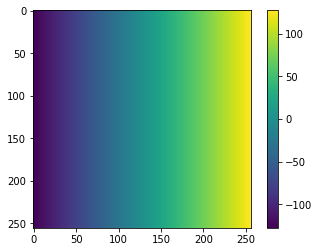

In [4]:
plt.imshow(grid[...,1])
plt.colorbar()

In [5]:
delta_pml = 110.

def sigma(X):
    on_pml = jops.elementwise(
        lambda x: jnp.where(
            jnp.abs(x) > delta_pml,
            (jnp.abs(jnp.abs(x)-delta_pml)/(128. - delta_pml)), 
            0.)
    )
    return 2.*on_pml(X)**2

@operator()
def grad_factor(X):
    return 1./(1 + 1j*sigma(X)/omega)

In [6]:
outfield = grad_factor(X=X)
global_params = outfield.get_global_params()

# Can use directly this on a GridBased discretization
pml_on_grid = outfield.get_field_on_grid(0)(global_params, {'X': {}})

# Or can use the PML function, if the downstream task requires it.
pml_f = lambda x: outfield.get_field(0)(global_params, {'X': {}}, x)

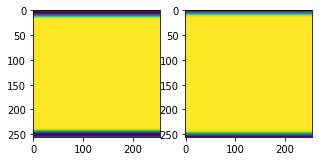

In [7]:
fig, ax = plt.subplots(1,2,figsize=(5,12))
ax[0].imshow(pml_on_grid[...,0].imag)
ax[1].imshow(pml_on_grid[...,0].real)

# Modified $\nabla^2$ operator

In [8]:
def laplacian(u, pml):
    grad_u = jops.gradient(u)
    mod_grad_u = grad_u*pml
    mod_diag_jacobian = jops.diag_jacobian(mod_grad_u)*pml
    return jops.sum_over_dims(mod_diag_jacobian)

## Helmholtz operator

In [9]:
@operator()
def helmholtz(u, c, pml):
    # Get the modified laplacian
    L = laplacian(u, pml)
    
    # Add the wavenumber term
    k = ((omega/c)**2)*u
    
    return L + k

Let's make the operator concrete by specifying the discretizations

In [10]:
from jwave.discretization import FourierSeries

# Initialize discretizations
fourier_discr = FourierSeries(domain)

# Initialize parameters (we already have the PML parameters)
u_fourier_params = fourier_discr.empty_field()
src_fourier_params = u_fourier_params.at[64,64].set(1. + 0j)  # Source field, using Fourier discretization
c_fourier_params = u_fourier_params + 1.                      # Uniform SoS of 1.
c_fourier_params = c_fourier_params.at[20:40,20:100].set(2.)
c_fourier_params = c_fourier_params.at[20:200,150:200].set(1.5)

# Create fields
u = Field(fourier_discr, params=u_fourier_params, name='u')
c = Field(fourier_discr, params=c_fourier_params, name='c')
src = Field(fourier_discr, params=src_fourier_params, name='src')
pml = Field(fourier_discr, params=pml_on_grid, name='pml')

In [11]:
# Make the computational graph
Hu = helmholtz(u=u, c=c, pml=pml)
global_params = Hu.get_global_params()

def helm_func(u):
    return Hu.get_field_on_grid(0)(
        global_params,
        {"u":u, "c":c_fourier_params, "pml":pml_on_grid}
    )

In [13]:
helm_func(u_fourier_params).shape

(256, 256, 1)

In [14]:
from jax.scipy.sparse.linalg import gmres
from functools import partial

sol, _ = gmres(helm_func, src_fourier_params, maxiter=10000)

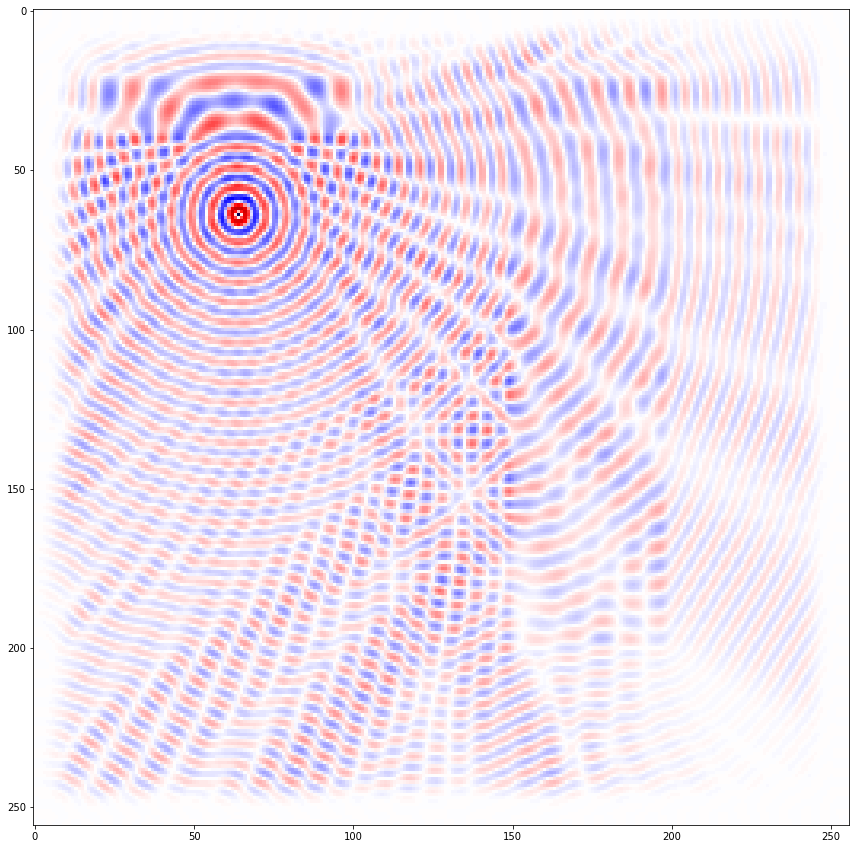

In [15]:
plt.figure(figsize=(15,15))
plt.imshow(sol.real, cmap="seismic", vmin=-.2, vmax=.2)